<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>


# Modeling stream-based species

<hr>
<small> For instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

In this tutorial we will:
* Introduce species into a Landlab model.
* Set the zones in which the species operate.
* Evolve a landscape and the species over time.
* Explore SpeciesEvolver output data structures.

The configuration of the model in this tutorial loosely follows the fault throw experiment in Lyons et al., in preperation for Earth Surface Dynamics.

## Macroevolution processes built into species

The evolution of the base species is driven by these processes:
* dispersal: geographic range expansion
* speciation: lineage splitting
* extinction: lineage termination

Import modules.

In [1]:
from copy import deepcopy
from landlab.components import (SpeciesEvolver, FastscapeEroder, FlowRouter,
                                LinearDiffuser)
from landlab.components.species_evolution import Species, StreamZoneManager
from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
import numpy as np

/Users/njlyons/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## Prepare the grid and components of the model.

Load a model grid that has steady state topography. The top and bottom boundaries are set to open.

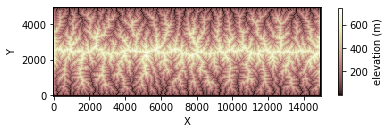

In [2]:
(mg, z) = read_esri_ascii('model_grid_steady_state_elevation.txt')
mg.at_node['topographic__elevation'] = z
mg.set_closed_boundaries_at_grid_edges(right_is_closed=True,
                                       top_is_closed=False,
                                       left_is_closed=True,
                                       bottom_is_closed=False)

imshow_grid(mg, z, colorbar_label='elevation (m)', shrink=0.4)

Initialize the components that will be run alongside SpeciesEvolver. 

In [3]:
fr = FlowRouter(mg)
sp = FastscapeEroder(mg, K_sp=5e-5, m_sp=0.5, n_sp=1.0)
lf = LinearDiffuser(mg, linear_diffusivity=1e-3)

fr.run_one_step()

Initialize SpeciesEvolver.

SpeciesEvolver requires only one parameter, a model grid, for the default functionality.


In [5]:
szm = StreamZoneManager(mg, min_drainage_area=50000)

# Instaniate SpeciesEvolver and get initial zones.
se = SpeciesEvolver(mg, zone_managers=[szm])
zones = se.zones_at_time(0)

stream_mask = mg.at_node['drainage_area'] > 50000
imshow_grid(mg, stream_mask, allow_colorbar=False)

NameError: name 'StreamZoneManager' is not defined

Populate each zone with a species.

In [5]:
for zone in zones:
    species = Species(zone)
    se.introduce_species(species)

NameError: name 'zones' is not defined

## Initiate a fault

Define the faults. A block in the center of the grid uplifts.

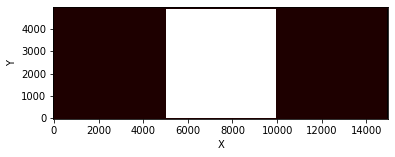

In [6]:
x_of_fault_1 = mg.x_of_node > 5000
x_of_fault_2 = mg.x_of_node < 10000
core_mask = mg.node_is_core()
upthown_block_mask = np.all([core_mask, x_of_fault_1, x_of_fault_2], 0)

imshow_grid(mg, upthown_block_mask, allow_colorbar=False)

Uplift the nodes of the upthrown block by 50 m.

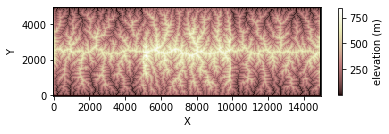

In [7]:
z[upthown_block_mask] += 100
imshow_grid(mg, z, colorbar_label='elevation (m)', shrink=0.4)

## Model species evolution

First, set model time step and uplift parameters.

SpeciesEvolver runs every 10 timesteps of the other components.

In [8]:
dt = 1000
total_time = int(5e5)
nt = int(total_time // dt)

dt_se = 10 * dt

uplift_rate = 5e-3
uplift_per_step = uplift_rate * dt

mg0 = deepcopy(mg)

Run model. The ```run_one_step``` function of SpeciesEvolver takes the new zones of the time step.

This code block may take a few minutes to run.

In [9]:
for time_i in range(nt):
    # Uniformly uplift.
    z[mg.core_nodes] += uplift_per_step

    # Increment earth surface process components.
    fr.run_one_step()
    sp.run_one_step(dt)
    lf.run_one_step(dt)

    elapsed_time = dt * (time_i + 1)

    if elapsed_time % dt_se == 0:
        # Increment SpeciesEvolver.
        se.run_one_step(dt)

In [10]:
se.record

OrderedDict([('time',
              [0,
               1000,
               2000,
               3000,
               4000,
               5000,
               6000,
               7000,
               8000,
               9000,
               10000,
               11000,
               12000,
               13000,
               14000,
               15000,
               16000,
               17000,
               18000,
               19000,
               20000,
               21000,
               22000,
               23000,
               24000,
               25000,
               26000,
               27000,
               28000,
               29000,
               30000,
               31000,
               32000,
               33000,
               34000,
               35000,
               36000,
               37000,
               38000,
               39000,
               40000,
               41000,
               42000,
               43000,
               44000,
 

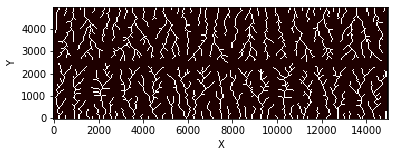

In [11]:
imshow_grid(mg, stream_mask, allow_colorbar=False)

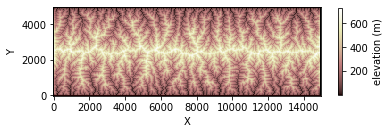

In [12]:
imshow_grid(mg, z, colorbar_label='elevation (m)', shrink=0.4)

Plot difference of pre and post fault topography.

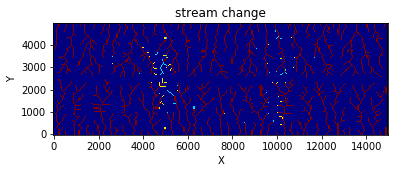

In [18]:
A_c = 50000

stream_change = np.zeros(mg.number_of_nodes)

a0 = mg0.at_node['drainage_area']
stream_change[a0 > A_c] = 1

a1 = mg.at_node['drainage_area']
stream_change[a1 > A_c] = 2

stream_change[np.all([a0 > A_c, a1 > A_c], 0)] = 3

cm = plt.cm.get_cmap('jet', 4)
imshow_grid(mg, stream_change, cmap=cm,
            allow_colorbar=False, plot_name='stream change')

## Plot results



In [ ]:
plt.subplot(1, 2, 1)
imshow_grid(mg, 'topographic__elevation', colorbar_label='elevation (m)')

plt.subplot(1, 2, 2)
plot.imshow_zones(mg, zones)

plot.number_of_species(se.record, se.species)

In [ ]:
from landlab.components.species_macroevolution import plot

plot.tree(se.species)

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>